In [1]:
from scipy.signal import spectrogram, resample
import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np
import time
import os
from collections import defaultdict
import librosa.core as lr

(1818752,)
44100


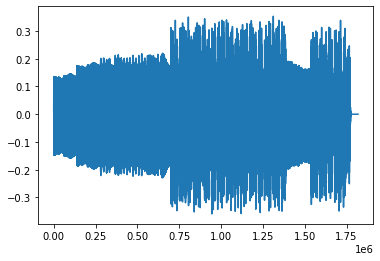

In [2]:
# Read file

audio, rate = sf.read("Samples/337653__hmmm101__pixel-song-19.wav")

print(audio.shape)
plt.plot(audio)
print(rate)

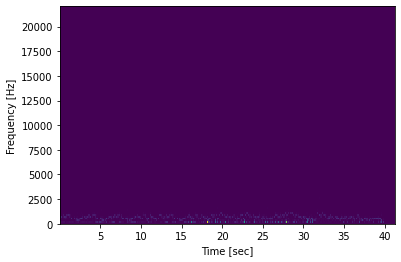

In [3]:
f, t, Sxx = spectrogram(audio, rate)

plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [4]:
def to_mono(audio):
    if len(audio.shape) < 2:
        # already mono
        return audio
    num_channels = audio.shape[1]
    if num_channels > 2:
        # because I'm not sure how to deal with 5.1 etc
        raise Exception("Can only deal with stereo or mono input")
    return (audio[:, 0] + audio[:, 1]) / 2

def graph_audio(filename):
    audio, rate = sf.read(filename)
    print(f"{rate}Hz")
    audio = to_mono(audio)
    plt.plot(audio)
    plt.show()
    f, t, Sxx = spectrogram(audio, rate)
    plt.pcolormesh(t, f, Sxx)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    return f, t, Sxx

44100Hz


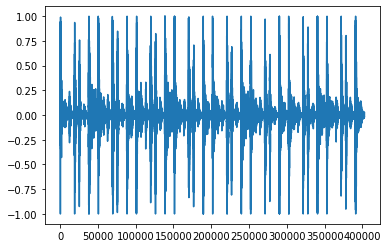

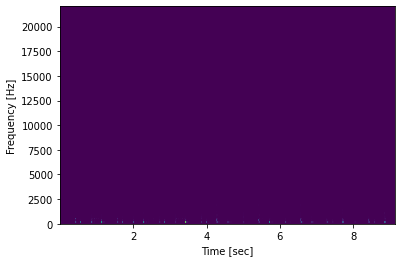

In [5]:
rumba_f = "/home/cameron/src/abracadabra/Samples/337443__nemaavla__greek-rumba.wav"
f, t, Sxx = graph_audio(rumba_f)

f: (129,)
t: (1797,)
Sxx: (129, 1797)
[[1.31115635e-06 4.67891359e-06 1.42058059e-05]
 [5.08625219e-04 2.23133178e-03 1.57886409e-03]
 [2.40281496e-05 9.68776500e-05 1.62512364e-04]
 [7.10148438e-07 7.36073291e-06 5.41088529e-05]
 [2.80069830e-06 1.44887630e-07 9.51127905e-06]
 [6.46889791e-07 1.11231252e-06 3.89169115e-06]
 [1.80576201e-06 4.41622091e-06 5.39140573e-06]
 [7.15994322e-06 3.67990190e-06 7.42097553e-06]
 [1.16386667e-07 1.10613358e-06 5.51872824e-06]
 [3.11962887e-07 3.57456553e-06 5.70679737e-07]
 [2.82648708e-06 4.76066207e-07 6.32169155e-07]
 [1.16847006e-06 7.85803794e-07 7.90888125e-09]
 [1.73220580e-06 3.04231498e-07 2.89298116e-08]
 [1.22604302e-06 6.15341995e-07 1.14429666e-07]
 [4.06536548e-07 1.39315041e-07 1.14960158e-07]
 [1.09396494e-06 5.84613896e-08 3.68214026e-07]
 [1.84192891e-06 2.41595618e-07 1.41749431e-07]
 [1.96598038e-08 6.60842302e-08 1.10914813e-07]
 [5.11813972e-07 3.47797118e-08 2.07447158e-07]
 [5.79770520e-07 1.31169207e-08 2.93580305e-08]
 [

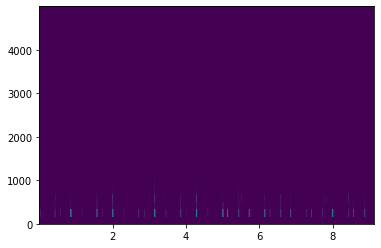

In [6]:
# This is me being concerned by the amount of purple in the above image
print(f"f: {f.shape}\nt: {t.shape}\nSxx: {Sxx.shape}")

f_cut = f[:30]
Sxx_cut = Sxx[:30, :]

plt.pcolormesh(t, f_cut, Sxx_cut)

print(Sxx_cut[:, :3])

Time to turn the spectrogram into a constellation map.

Need to pick the peaks in the spectrogram but space them using some density variable. I think this density variable could be the side length of a square. The spectrogram could then be split into a grid of these component squares and the peak from each of these squares picked. If this doesn't work, then maybe a (time, freq) tuple could define a rectangle to be used in the same way.

In the paper, they only use frequencies up to 4000Hz. From a quick Google search, that sounds reasonable. https://www.psbspeakers.com/the-frequencies-of-music/ 5KHz covers most of the range of instruments.

So, steps:
 - Cut spectrogam to 5KHz
 - Iterate through the "squares" in this spectrogram and find the peak in each one
 - Graph this constellation map
 
Questions:
 - Is it better to downsample the audio, or cut the spectrum?
   - My intuition is that it would be better to cut the spectrum since downsampling the audio could introduce aliasing. It might depend on how well I can control the number of FFT bins in the spectrogram.
   - Actually, it looks like downsampling is valid https://dsp.stackexchange.com/questions/30374/the-relationship-between-downsampling-and-frequency-resolution
 - What window should I use?
   - Tukey looks fine, but the nperseg parameter looks like it would increase my resolution. nperseg controls how many samples are used per time-sample

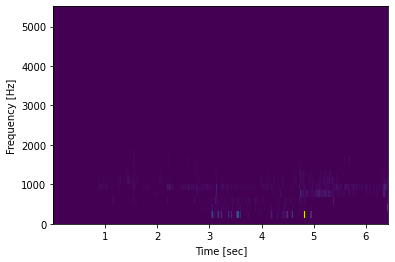

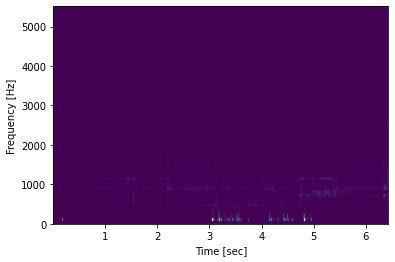

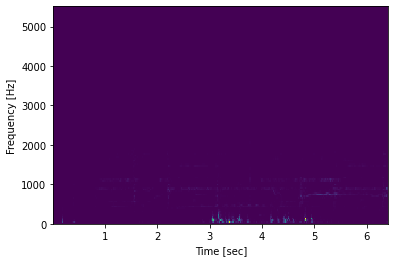

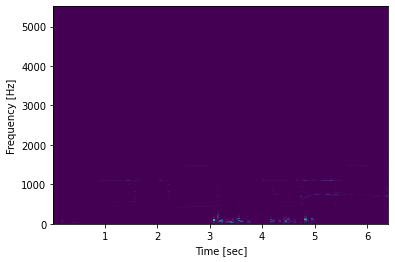

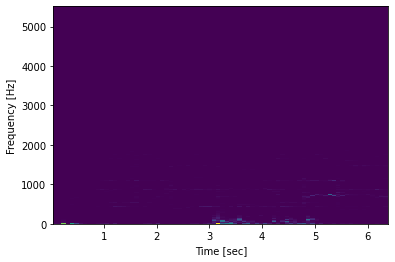

In [7]:
# Various nperseg values

test_muse = "/home/cameron/src/abracadabra/Samples/test.wav"

audio, rate = sf.read(test_muse)
audio = to_mono(audio)

new_rate = 11025
num_samples_required = int(audio.size / (rate / new_rate))

downsampled = resample(audio, num_samples_required)

# 256 is something like 23ms
n64   = spectrogram(downsampled, new_rate, nperseg=64)
# 128 feels right (~10ms)
n128  = spectrogram(downsampled, new_rate, nperseg=128)
n256  = spectrogram(downsampled, new_rate, nperseg=256)
n512  = spectrogram(downsampled, new_rate, nperseg=512)
n1024 = spectrogram(downsampled, new_rate, nperseg=1024)

def graph_spectrogram_result(f, t, Sxx, title=None):
    plt.pcolormesh(t, f, Sxx)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    if title is not None:
        plt.title(title)
    plt.show()
    
graph_spectrogram_result(*n64)
graph_spectrogram_result(*n128)
graph_spectrogram_result(*n256)
graph_spectrogram_result(*n512)
graph_spectrogram_result(*n1024)

In [2]:
def downsample(audio, orig_rate, target_rate):
    num_samples_required = int(audio.size / (orig_rate / target_rate))
    return resample(audio, num_samples_required)

def my_spectrogram(audio, sample_rate):
    # aim for 100ms segments (allows for 600BPM music)
    nperseg = int(sample_rate / 10)
    return spectrogram(audio, sample_rate, nperseg=nperseg)

def file_to_spectrogram(filename):
    audio, rate = sf.read(filename)
    audio = downsample(to_mono(audio), rate, 11025)
    return my_spectrogram(audio, 11025)

In [3]:
def lr_file_to_spectrogram(filename):
    audio, rate = lr.load(filename, sr=11025, mono=True)
    return my_spectrogram(audio, 11025)

In [10]:
a = np.array([[1, 2, 3], [4, 5, 6]])
print(a.shape)

(2, 3)


In [11]:
def chunk_generator_2d(arr, x_size, y_size):
    for y in range(0, arr.shape[0], y_size):
        for x in range(0, arr.shape[1], x_size):
            yield arr[y:y+y_size, x:x+x_size], y, x

# test above
test_arr = np.array([np.arange(5), np.arange(5)])
for elem in chunk_generator_2d(test_arr, 2, 2):
    print(elem)
    
print(test_arr)

(array([[0, 1],
       [0, 1]]), 0, 0)
(array([[2, 3],
       [2, 3]]), 0, 2)
(array([[4],
       [4]]), 0, 4)
[[0 1 2 3 4]
 [0 1 2 3 4]]


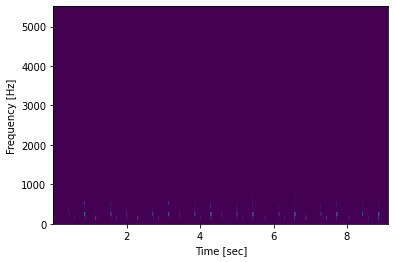

(56, 1037)


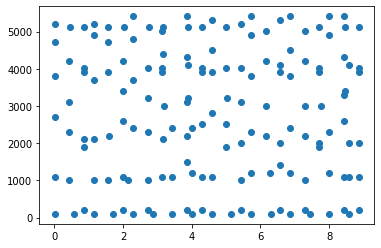

In [12]:
f, t, Sxx = file_to_spectrogram(rumba_f)

graph_spectrogram_result(f, t, Sxx)

print(Sxx.shape)

peaks_x = []
peaks_y = []

# spectrum, chunk width, chunk height
for chunk, y, x in chunk_generator_2d(Sxx, 40, 10):
    inds = np.unravel_index(np.argmax(chunk), chunk.shape)
    inds = [inds[0] + y, inds[1] + x]
    peaks_x.append(t[inds[1]])
    peaks_y.append(f[inds[0]])
    
plt.scatter(peaks_x, peaks_y)

I don't think the above is a correct way of finding the peaks because of the sentence

 > A  time-frequency  point  is  a  candidate  peak  if  it  has  a  higher  energy  content  than  all  its  neighbors  in  a  region  centered  around  the  point.
 
Maybe a search function would be more appropriate? Something like:
- Pick peak within `r` of upper-left corner of graph
- Then for every peak selected
  - Pick the peak between r and 2r away from that peak
  - Check it's not close to any existing peak
  - Remove it from consideration
- Until an iteration has no new peaks

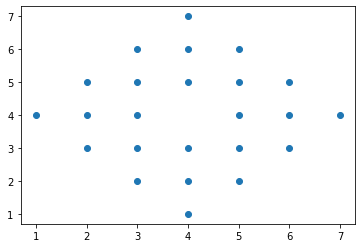

In [4]:
def neighbours_within(center, distance, shape):
    # using taxicab distance
    xs = []
    ys = []
    for x in range(-distance, distance+1):
        y_min = -(distance - abs(x))
        y_max = distance - abs(x)
        for y in range(y_min, y_max+1):
            if x == 0 and y == 0:
                continue
            new_x = center[1] + x
            new_y = center[0] + y
            if new_x < 0 or new_x >= shape[1]:
                continue
            if new_y < 0 or new_y >= shape[0]:
                continue
            ys.append(center[0] + y)
            xs.append(center[1] + x)
    return ys, xs

y, x = neighbours_within((4, 4), 3, (10, 10))
plt.scatter(x, y)
plt.show()

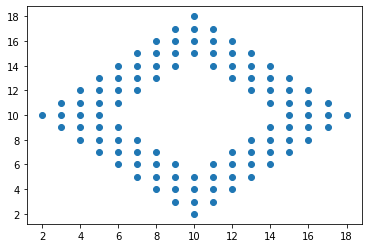

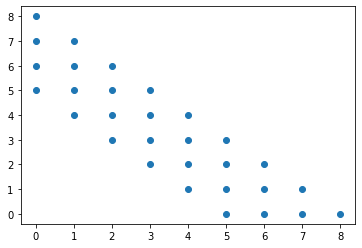

In [5]:
def donut_neighbours(center, distance, shape):
    # finds all neighbours within r and 2r of center
    outer = set(zip(*neighbours_within(center, 2*distance, shape)))
    inner = set(zip(*neighbours_within(center, distance, shape)))
    y, x = zip(*list(outer - inner))
    return y, x
    
y, x = donut_neighbours((10, 10), 4, (20, 20))
plt.scatter(x, y)
plt.show()

y, x = donut_neighbours((0, 0), 4, (20, 20))
plt.scatter(x, y)
plt.show()

In [6]:
def find_peaks_spaced(arr, distance):
    """ Ugly function that finds the points in a spectrogram with maximum power
        such that no two points are closer than `distance` together.
    """
    # so we can remove peaks from consideration
    temp_arr = arr.copy()
    peaks = []
    initial_neighbours = neighbours_within((0,0), distance, arr.shape)
    powers = temp_arr[initial_neighbours]
    max_power = np.argmax(powers)
    peak = initial_neighbours[0][max_power], initial_neighbours[1][max_power]
    peaks.append(peak)
    temp_arr[peak] = -np.inf
    temp_arr[initial_neighbours] = -np.inf
    new_peaks_found = True
    while new_peaks_found:
        new_peaks_found = False
        for peak in peaks:
            neighbours = donut_neighbours(peak, distance, arr.shape)
            powers = temp_arr[neighbours]
            max_power = np.argmax(powers)
            peak_candidate = neighbours[0][max_power], neighbours[1][max_power]
            for peak in peaks:
                if abs(peak_candidate[0] - peak[0]) + abs(peak_candidate[1] - peak[1]) < distance:
                    break
            else:
                peaks.append(peak_candidate)
                # don't look at neighbours of peak again
                neighbours = neighbours_within(peak_candidate, distance, arr.shape)
                temp_arr[neighbours] = -np.inf
                new_peaks_found = True
            # make sure we don't look at this peak again
            temp_arr[peak_candidate] = -np.inf
#         plt.pcolormesh(t, f, temp_arr)
#         plt.show()
    return peaks

peaks = find_peaks_spaced(Sxx, 20)
y, x = zip(*peaks)
plt.scatter(x, y)
plt.show()

# This looks a lot better spaced than the old method. How well it will work with matching is yet to be seen.

NameError: name 'Sxx' is not defined

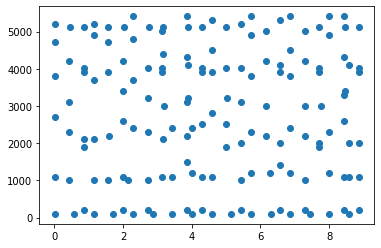

In [16]:
# just to remember what the old one looked like
plt.scatter(peaks_x, peaks_y)
plt.show()

Next we need to convert the indices into time/frequency pairs and store them in some kind of spatial data structure. We will need to run queries on rectangualr areas in this sructure.

It might be overall faster to just store them as is though, so maybe run some experiments.

In [7]:
def indices_to_tf_pairs(idxs, t, f):
    return np.array([(f[i[0]], t[i[1]]) for i in idxs])

new_scatter = indices_to_tf_pairs(peaks, t, f)
y, x = zip(*new_scatter)
plt.scatter(x, y)

NameError: name 'peaks' is not defined

Now comes time for hashing. Steps:

 - For each point in constellation map, define a target zone with width and height w and h. It will start t seconds after the anchor point.
 - For every point in that target zone, create a tuple (f1, f2, dt) where:
   - f1 is the frequency of the anchor point
   - f2 is the frequency of the point in the target zone
   - dt is the time delta between the two points
 - Run a hashing function on that tuple to generate a 32 bit integer
 - Associate that hash with the filename and time offset of the anchor point

New way of spacing peaks:
 - Sort spectrum by power descending
 - For point in spectrum
   - If too close to existing peaks
     - Continue
   - Add to peaks

Simpler and should be faster

In [9]:
# i = Sxx.argsort(axis=None)[::-1]

# j = np.unravel_index(i, Sxx.shape)

# v = np.vstack(j).T
# print(v)

# print(Sxx[11, 644])
# print(Sxx[18, 1])

# print(Sxx[v[0][0], v[0][1]])

# print(np.max(Sxx))

def find_peaks_fast(arr, distance, point_efficiency=0.4):
    # get sorted flattened indices descending
    i = arr.argsort(axis=None)[::-1]
    # get co-ordinates into arr
    j = np.vstack(np.unravel_index(i, arr.shape)).T
    peaks = []
    total = j.size
    e_peaks = (total / (distance**2)) * point_efficiency
    for point in j:
        if len(peaks) > e_peaks:
            break
        for peak in peaks:
            if abs(point[0] - peak[0]) + abs(point[1] - peak[1]) < distance:
                break
        else:
            peaks.append(point)
    print()
    return peaks

# peaks = find_peaks_fast(Sxx, 40)
# y, x = zip(*peaks)

# plt.scatter(x, y)

# print(Sxx.shape)

# plt.hist(Sxx.flatten(), bins=200, log=True)
# plt.show()

In [93]:
# start = time.time()
# peaks_old = find_peaks_spaced(Sxx, 40)
middle = time.time()
peaks_new = find_peaks_fast(Sxx, 40)
end = time.time()

# old_time = middle - start
new_time = end - middle

# print(f"Old: {len(peaks_old)} in {old_time}s\nNew: {len(peaks_new)} in {new_time}s")
print(f"Old: 746 in 64.4s\nNew: {len(peaks_new)} in {new_time}s")


Old: 746 in 64.4s
New: 511 in 10.006519556045532s


In [10]:
def target_zone(anchor, points, width, height, t):
    x_min = anchor[1] + t
    x_max = x_min + width
    y_min = anchor[0] - (height*0.5)
    y_max = y_min + height
    for point in points:
        if point[0] < y_min or point[0] > y_max:
            continue
        if point[1] < x_min or point[1] > x_max:
            continue
        yield point

targets = [t for t in target_zone(new_scatter[10], new_scatter, 1, 2000, 0.1)]

targets.append(new_scatter[0])

y, x = zip(*targets)
plt.scatter(x, y)

NameError: name 'new_scatter' is not defined

In [19]:
# Fan-out factor

num_points = 0
num_targets = 0
for point in new_scatter:
    num_points += 1
    num_targets += len(list(target_zone(point, new_scatter, 1, 2000, 0.1)))

print(f"Avg: {num_targets/num_points}")

Avg: 5.273684210526316


In [11]:
def hash_point_pair(p1, p2):
    return hash((p1[0], p2[0], p2[1]-p2[1]))

def hash_points(points, filename):
    hashes = []
    for anchor in points:
        for target in target_zone(anchor, points, 1, 2000, 0.1):
            hashes.append((hash_point_pair(anchor, target), anchor[1], filename))
    return hashes

start = time.time()
hashes = hash_points(new_scatter, rumba_f)
print(f"Took {time.time() - start}s")
print(len(hashes))

NameError: name 'new_scatter' is not defined

In [12]:
# putting it all together

def register_song(filename, distance=20):
    start = time.time()
    f, t, Sxx = lr_file_to_spectrogram(filename)
    spec = time.time()
    peaks = find_peaks_fast(Sxx, distance)
    peaks = indices_to_tf_pairs(peaks, t, f)
    p_time = time.time()
    h = hash_points(peaks, filename)
    h_time = time.time()
    print(f"Spectrogram: {spec - start}\nPeaks: {p_time - spec}\nHash: {h_time - p_time}")
    return h

In [22]:
# num_files = 0
# start = time.time()
# for file in os.listdir('Samples'):
#     start = time.time()
#     if file.split('.')[-1] != 'wav':
#         continue
#     register_song("Samples/" + file)
#     print(f"Registered {file} ({os.stat('Samples/' + file).st_size / (1024*1024)}MB) in {time.time() - start}s")

In [23]:
# folie_a_deux = "/media/cameron/Seagate Expansion Drive/Music/Dream Theater/Dream Theater/"

# num_hashes = 0

# with open('hash_db', 'w') as hash_db:
#     for file in os.listdir(folie_a_deux):
#         if file.split('.')[-1] != "flac":
#             continue
#         path = folie_a_deux + file
#         hashes = register_song(path, distance=40)
#         for h in hashes:
#             hash_db.write(",".join([str(x) for x in h]) + "\n")
#         print(f"Added {len(hashes)} hashes for {file}")
#         num_hashes += len(hashes)
#         del hashes

# print(num_hashes)

In [13]:
def find_matches(test_hashes, hash_db):
    results = defaultdict(list)
    for h in test_hashes:
        if h[0] in hash_db:
            filename = hash_db[h[0]][0]
            offset   = hash_db[h[0]][1]
            results[filename].append(offset)
    return results

In [96]:
dt = [
    "/media/cameron/Seagate Expansion Drive/Music/Dream Theater/Dream Theater/01-dream_theater-false_awakening_suite.flac",
    "/media/cameron/Seagate Expansion Drive/Music/Dream Theater/Dream Theater/02-dream_theater-the_enemy_inside.flac", 
    "/media/cameron/Seagate Expansion Drive/Music/Dream Theater/Dream Theater/03-dream_theater-the_looking_glass.flac"
]

del hash_db

hash_db = {}

for file in dt:
    hashes = register_song(file)
    filename = file.split('/')[-1]
    for h, offset, _ in hashes:
        hash_db[h] = filename, offset
    print(f"Registered {filename}")

files = defaultdict(int)
for h, f in hash_db.items():
    files[f[0]] += 1

from pprint import pprint

pprint(files)


Registered 01-dream_theater-false_awakening_suite.flac

Registered 02-dream_theater-the_enemy_inside.flac

Registered 03-dream_theater-the_looking_glass.flac
defaultdict(<class 'int'>,
            {'01-dream_theater-false_awakening_suite.flac': 4001,
             '02-dream_theater-the_enemy_inside.flac': 11248,
             '03-dream_theater-the_looking_glass.flac': 11731})


-----lookingglass1.wav-----



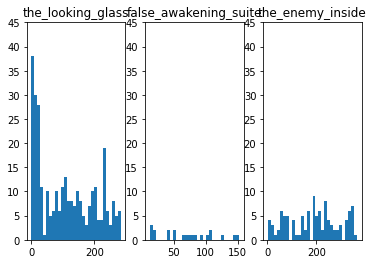

-----enemyinside2.wav-----



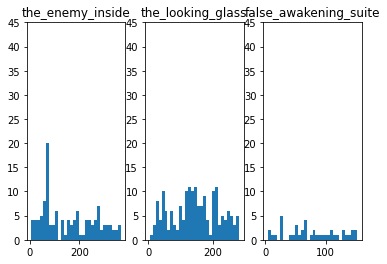

-----falseawakening3.wav-----



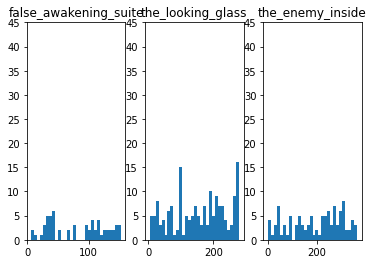

-----enemyinside3.wav-----



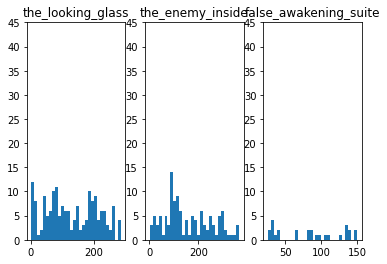

-----kissfromarose1.wav-----



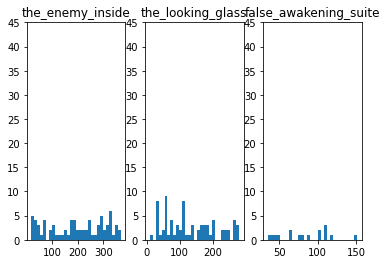

-----enemyinside1.wav-----



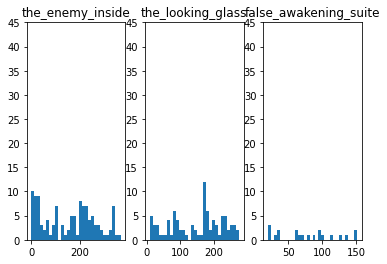

-----falseawakening4.wav-----



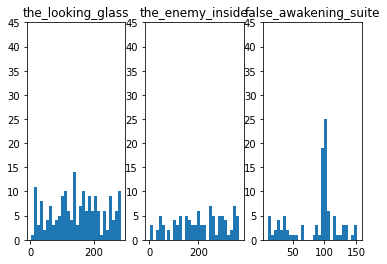

-----lookingglass2.wav-----



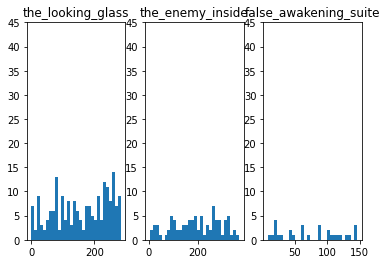

-----lookingglass4.wav-----



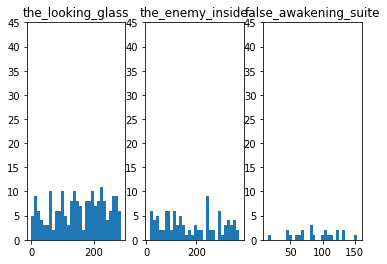

-----sixhome2.wav-----



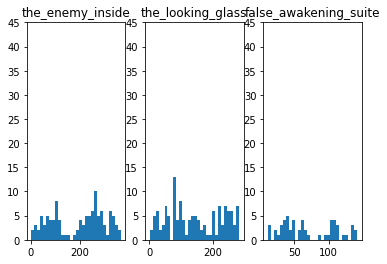

-----kissfromarose2.wav-----



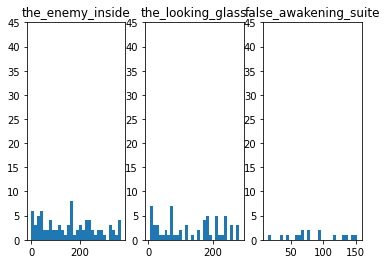

-----littlesister1.wav-----



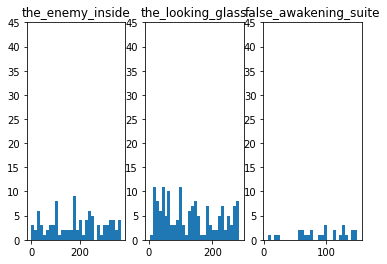

-----keepmeinmind2.wav-----



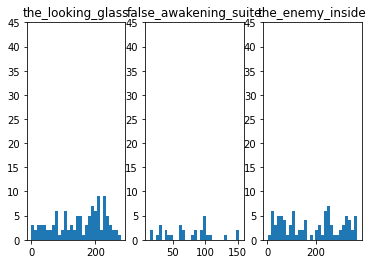

-----sixhome1.wav-----



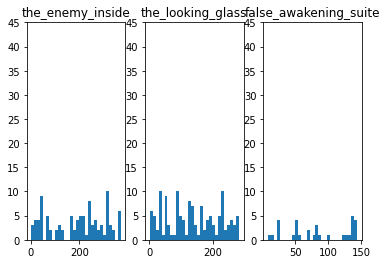

-----falseawakening1.wav-----



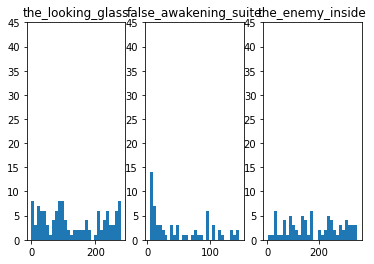

-----lookingglass3.wav-----



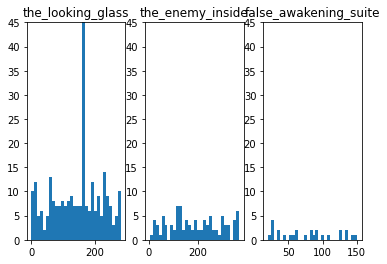

-----keepmeinmind1.wav-----



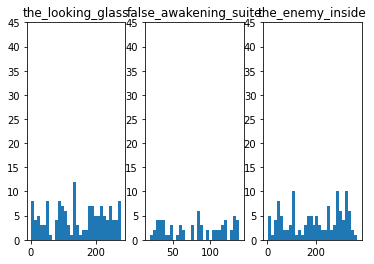

-----falseawakening2.wav-----



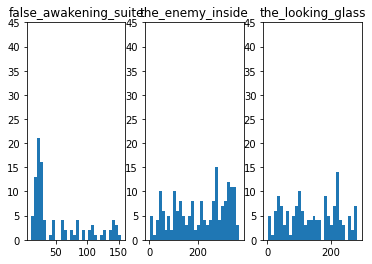

-----enemyinside4.wav-----



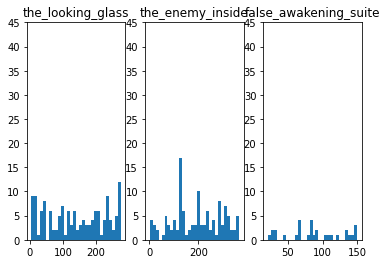

-----littlesister2.wav-----



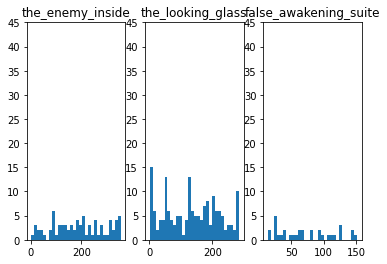

In [97]:
for song in os.listdir('test'):
    print("-" * 5 + song + "-" * 5)
    hashes = register_song('test/' + song)
    matches = find_matches(hashes, hash_db)
    num_plots = len(matches)
    idx = 1
    for file in matches:
        plt.subplot(1, len(matches), idx)
        plt.hist(matches[file], bins=30)
        plt.title(file.split('-')[2].split('.')[0])
        plt.ylim(0, 45)
        idx += 1
    plt.show()

In [28]:
ab_odr = "/media/cameron/Seagate Expansion Drive/Music/Alter Bridge/(2004) One Day Remains/"

# del hash_db

hash_db = {}

for filename in os.listdir(ab_odr):
    if filename.split('.')[-1] != "mp3":
        continue
    file = ab_odr + filename
    hashes = register_song(file, distance=30)
    for h, offset, _ in hashes:
        hash_db[h] = filename, offset
    print(f"Registered {filename}")

files = defaultdict(int)
for h, f in hash_db.items():
    files[f[0]] += 1

from pprint import pprint

pprint(files)

/home/cameron/src/abracadabra/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')



Spectrogram: 13.968217611312866
Peaks: 114.74108815193176
Hash: 1.8978400230407715
Registered Alter Bridge - Broken Wings.mp3


/home/cameron/src/abracadabra/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')



Spectrogram: 15.96543002128601
Peaks: 199.25298595428467
Hash: 2.8099076747894287
Registered Alter Bridge - Burn It Down.mp3


/home/cameron/src/abracadabra/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')



Spectrogram: 11.193392992019653
Peaks: 75.82815885543823
Hash: 1.7569191455841064
Registered Alter Bridge - Down To My Last.mp3


/home/cameron/src/abracadabra/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')



Spectrogram: 11.229958534240723
Peaks: 55.10985016822815
Hash: 1.6941003799438477
Registered Alter Bridge - Find The Real.mp3


/home/cameron/src/abracadabra/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')



Spectrogram: 13.15942668914795
Peaks: 215.17321038246155
Hash: 2.374281406402588
Registered Alter Bridge - In Loving Memory.mp3


/home/cameron/src/abracadabra/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')



Spectrogram: 11.227506399154663
Peaks: 56.91264319419861
Hash: 1.3852155208587646
Registered Alter Bridge - Metalingus.mp3


/home/cameron/src/abracadabra/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')



Spectrogram: 10.58066725730896
Peaks: 39.25010418891907
Hash: 1.244330644607544
Registered Alter Bridge - One Day Remains.mp3


/home/cameron/src/abracadabra/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')



Spectrogram: 12.877065658569336
Peaks: 83.29153752326965
Hash: 1.8790416717529297
Registered Alter Bridge - Open Your Eyes.mp3


/home/cameron/src/abracadabra/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')



Spectrogram: 13.381843566894531
Peaks: 120.5378770828247
Hash: 1.9416508674621582
Registered Alter Bridge - Shed My Skin.mp3


/home/cameron/src/abracadabra/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')



Spectrogram: 13.816329956054688
Peaks: 106.80971193313599
Hash: 1.8503797054290771
Registered Alter Bridge - The End Is Here.mp3


/home/cameron/src/abracadabra/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')



Spectrogram: 13.982231855392456
Peaks: 86.1352961063385
Hash: 2.1412384510040283
Registered Alter Bridge - Watch Your Words.mp3
defaultdict(<class 'int'>,
            {'Alter Bridge - Broken Wings.mp3': 1578,
             'Alter Bridge - Burn It Down.mp3': 1913,
             'Alter Bridge - Down To My Last.mp3': 1572,
             'Alter Bridge - Find The Real.mp3': 1787,
             'Alter Bridge - In Loving Memory.mp3': 1944,
             'Alter Bridge - Metalingus.mp3': 1890,
             'Alter Bridge - One Day Remains.mp3': 1713,
             'Alter Bridge - Open Your Eyes.mp3': 2093,
             'Alter Bridge - Shed My Skin.mp3': 2408,
             'Alter Bridge - The End Is Here.mp3': 2535,
             'Alter Bridge - Watch Your Words.mp3': 2904})


In [39]:
from operator import itemgetter

for song in os.listdir('test/ab/'):
    print("-" * 5 + song + "-" * 5)
    hashes = register_song('test/ab/' + song, distance=30)
    matches = find_matches(hashes, hash_db)
    f_len = []
    for f, m in matches.items():
        if len(m) < 5:
            continue
        # Number of matches / standard deviation of the time offsets of those matches
        # Standard deviation represents whether the matches are all at one point in a song or spread out
        # at one point (low) means more likely to be a real match
        # add max offset to the standard deviation to prevent dividing by zero
        # while being equal to all other standard deviations
        f_len.append((f, len(m)/(np.std(m) + np.max(m)), len(m)))
    f_len = sorted(f_len, key=itemgetter(1), reverse=True)
    for f, score, l in f_len:
        print(f, score, l)

-----openyoureyes1.wav-----

Spectrogram: 0.46103453636169434
Peaks: 0.11175322532653809
Hash: 0.002478361129760742
Alter Bridge - Open Your Eyes.mp3 0.033854610456127796 13
Alter Bridge - Shed My Skin.mp3 0.022214289859545943 8
-----burnitdown2.wav-----

Spectrogram: 0.5015504360198975
Peaks: 0.13378214836120605
Hash: 0.0030655860900878906
Alter Bridge - Burn It Down.mp3 0.0638566274590454 24
Alter Bridge - In Loving Memory.mp3 0.033961470738003485 13
Alter Bridge - Shed My Skin.mp3 0.03140958528166984 12
Alter Bridge - Metalingus.mp3 0.024416270776734895 8
Alter Bridge - Watch Your Words.mp3 0.01913154991612676 6
Alter Bridge - Open Your Eyes.mp3 0.012383535168728357 5
-----openyoureyes2.wav-----

Spectrogram: 0.4520149230957031
Peaks: 0.10809516906738281
Hash: 0.002353191375732422
Alter Bridge - Shed My Skin.mp3 0.038574861238889396 13
Alter Bridge - Open Your Eyes.mp3 0.03790868672139288 13
Alter Bridge - Watch Your Words.mp3 0.024162994540607823 8
-----brokenwings2.wav-----

Spect

In [30]:
with open('hash_db', 'r') as hash_file:
    hash_db = {}
    for line in hash_file:
        h, _, filename = line.strip().split(',')
        hash_db[int(h)] = filename

files = defaultdict(int)
for h, f in hash_db.items():
    files[f] += 1

from pprint import pprint

pprint(files)
# for song in os.listdir('test'):
#     print("-" * 5 + song + "-" * 5)
#     hashes = register_song('test/' + song)
#     print(find_matches(hashes, hash_db))

defaultdict(<class 'int'>,
            {'/media/cameron/Seagate Expansion Drive/Music/Dream Theater/Dream Theater/01-dream_theater-false_awakening_suite.flac': 31,
             '/media/cameron/Seagate Expansion Drive/Music/Dream Theater/Dream Theater/02-dream_theater-the_enemy_inside.flac': 155,
             '/media/cameron/Seagate Expansion Drive/Music/Dream Theater/Dream Theater/03-dream_theater-the_looking_glass.flac': 610})


(552, 1851)


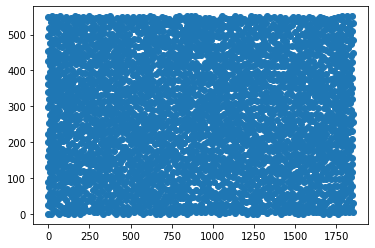

In [38]:
f, t, Sxx = file_to_spectrogram("/media/cameron/Seagate Expansion Drive/Music/Dream Theater/Dream Theater/01-dream_theater-false_awakening_suite.flac")
print(Sxx.shape)
peaks = find_peaks_spaced(Sxx, 20)

y, x = zip(*peaks)
plt.scatter(x, y)

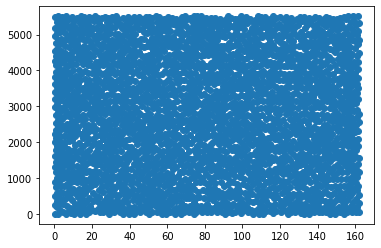

13260
11639


In [39]:
# debugging cell
peaks = indices_to_tf_pairs(peaks, t, f)

y, x = zip(*peaks)
plt.scatter(x, y)
plt.show()

hashes = hash_points(peaks, "01")

print(len(hashes))

# teaches us that hashes can occur multiple times in a file at different offsets.
# Probably should have a primary key of the entire tuple
h = set([x[0] for x in hashes])
print(len(h))